Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


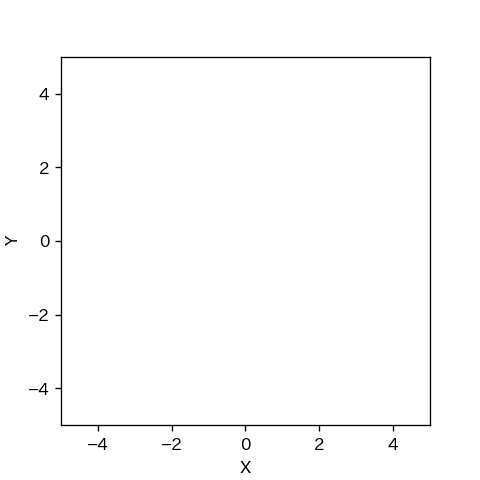

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_kidnap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
#  phantom_prob=0.1
    world.draw()
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


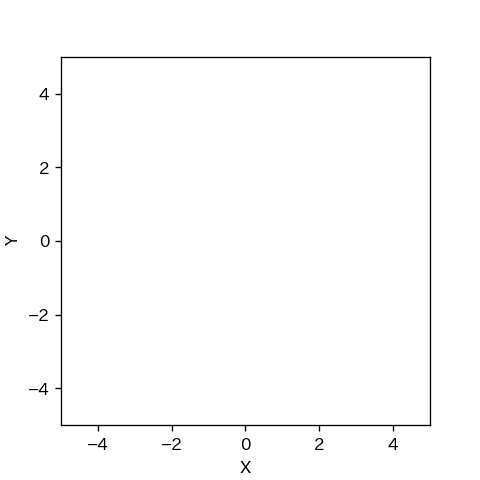

(array([-3.4517335 , -3.62232046,  0.17026328]),
 array([ 0.11973137, -3.22532192,  2.24778995]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[2.808971877373316]
0 真値: [-0.70883903  3.27739253  3.09769567] 推定値: [-0.58995091  3.30461174  3.15842536] 誤差: 0.12196422549340852
1
1 真値: [4.35201961 5.41447583 3.66359778] 推定値: [-0.3530157  -1.44859553  6.6163156 ] 誤差: 8.321003887928972
[3.0415684507284717]
[5.507488486126125]
2 真値: [-1.59007028 -3.40404263  6.03609312] 推定値: [-1.80374731 -2.38907453  5.73954073] 誤差: 1.0372165244274454
[6.047974520565105]
3 真値: [2.4245814  2.93481806 7.77771029] 推定値: [2.51927308 2.68801434 1.82553988] 誤差: 0.2643455873665939
2
[2.0440358434729458]
4 真値: [ 1.7172286  -0.04896826  3.01061449] 推定値: [ 1.95729738 -0.3455377   2.85815194] 誤差: 0.3815579275804218
3
[1.3332654057369175]
5 真値: [-3.49604147  1.44633891  9.09131166] 推定値: [-3.49806293  1.34554952  8.97602918] 誤差: 0.10080966579307717
4
[6.8303152848950655, 4.94042641898926]
6 真値: [-4.44130426 -3.62401061  5.97406804] 推定値: [-5.94978944 -3.24128807  5.09313665] 誤差: 1.556278925656071
[5.606622166031392]
[7.076219312344725]
7 真値: [-2.62452486 -4.7432049

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[5.210730557133372]
[5.782884173238457, 5.677919094847256]
20 真値: [-4.12331325 -3.45567432  5.02957619] 推定値: [-5.14432324 -3.20058883  4.95693144] 誤差: 1.0523925141478767
[2.996081540172077]
21 真値: [-0.99269271 -1.59260203  3.91296647] 推定値: [-0.81290318 -2.55616909  4.01198432] 誤差: 0.9801967906643876
13
[3.085182818859275]
22 真値: [0.06827479 4.56273729 4.69304508] 推定値: [-0.11549505  5.31493868  4.78811909] 誤差: 0.7743244030661888
14
[6.866217138385389]
23 真値: [-3.66046786 -4.93643153  6.63323376] 推定値: [ 1.31114879 -3.12010182  7.4539185 ] 誤差: 5.293016695953327
[1.8715778332737467]
24 真値: [ 4.24538424 -4.33147197  2.13792662] 推定値: [ 2.63604571 -0.56052275  3.96673353] 誤差: 4.100003475569609
[2.49081690433541]
25 真値: [ 1.13110131 -0.82889419  6.53541703] 推定値: [ 1.21545509 -1.12229635  6.37170431] 誤差: 0.30528738114316295
15
[4.436458695793832]
26 真値: [-3.47431886 -2.88323159  7.8064462 ] 推定値: [-4.58223488 -2.15210822  7.58216968] 誤差: 1.3274107417676124
27 真値: [-5.09934096 -1.90550688  5.0845